# Using Tractor catalog for positions

In [41]:
import matplotlib.pyplot as plt
from astropy.io import fits as fits

# version dependencies are currently an issue
import pkg_resources
pkg_resources.require("numpy==1.26.3")
import numpy as np

# import json
# import requests
from dl import authClient as ac, queryClient as qc
import pandas as pd

## Image query

In [42]:
def query_tractor(ra_b, dec_b, dist):
    """Queries the Astro Data Lab for the ra, dec and mag_g of the objects within a square of side length (dist).     
    dist is in degrees
    """
    #Bounds of the square we are querying objects for
    ra_min=ra_b
    ra_max = ra_b + dist
    dec_min=dec_b
    dec_max = dec_b + dist

    query = f"""
    SELECT ra, dec, mag_g
    FROM ls_dr10.tractor_s
    WHERE ra >= ({ra_min}) AND ra < ({ra_max})
    AND dec >= ({dec_min}) AND dec < ({dec_max})
    AND mag_g <= 21 AND mag_g >= 16
    """
    
    print("Querying the Astro Data Lab...")
    # check if this completes successfuly
    brick_info = qc.query(sql=query, fmt="pandas")
    return brick_info

tractor_df = query_tractor(0, 0, 1.0)

Querying the Astro Data Lab...


In [43]:
#for ra_b in [0,1]:
    #for dec_b in [-90,-89]:
       # info=query_tractor(ra_b,dec_b,dist=1)
       # print(info)

In [ ]:
# masking for low magnitude objects

def mask_radius(mag_g, fov_radius=20):
    return (fov_radius/3600) + 1630./3600. * 1.396**(-mag_g)

rad = mask_radius(tractor_df['mag_g'])

coords_df = pd.DataFrame(dict(ra=tractor_df['ra'], dec=tractor_df['dec'], radius=rad)).reset_index()
coords_df

,index,ra,dec,radius
0,0,0.078990,0.013123,0.006127
1,1,0.078851,0.105726,0.006258
2,2,0.205316,0.028401,0.006021
3,3,0.193515,0.067243,0.006084
4,4,0.208100,0.057905,0.006464
...,...,...,...,...
3045,3045,0.991848,0.977234,0.006109
3046,3046,0.956724,0.991512,0.006863
3047,3047,0.965541,0.991770,0.006537
3048,3048,0.984671,0.979338,0.005995


## Get bitmask info

Positions and masking radius for stars with magnitudes <16 are listed in the `mask_data_box[N].npz` files. Each index is a different range of RA / DEC:

| index | (RA1, DEC1) | (RA2, DEC2) |
| ----- | ----------- | ----------- |
| 0 | (0, -90) | (120, -60) |
| 1 | (0, -60) | (120, -30) |
| 2 | (0, -30) | (120, 0) |
| 3 | (0, 0) | (120, 30) |
| 4 | (120, -90) | (240, -60) |
| 5 | (120, -60) | (240, -30) |
| 6 | (120, -30) | (240, 0) |
| 7 | (120, 0) | (240, 30) |
| 8 | (240, -90) | (360, -60) |
| 9 | (240, -60) | (360, -30) |
| 10 | (240, -30) | (360, 0) |
| 11 | (240, 0) | (360, 30) |

In [45]:
# there will be a text file to read from at some point lol
with np.load("mask_data_box_3.npz", mmap_mode='r') as mask_data:
    # print(mask_data['arr_0'][.dtype.byteorder)
    mask_array = mask_data['arr_0']
    mask_array_byteswap = mask_array.byteswap().newbyteorder()
    masked_stars = pd.DataFrame(mask_array_byteswap)

,ra,dec,radius
0,113.562821,29.986300,0.007281
1,113.694974,29.973470,0.006407
2,113.630512,29.898099,0.005688
3,113.503645,29.930417,0.005661
4,113.737200,29.902361,0.005404
...,...,...,...
1458087,78.916855,0.069697,0.002268
1458088,78.786188,0.061842,0.002262
1458089,78.956871,0.043090,0.002261
1458090,78.886796,0.024846,0.002260


In [61]:
# you can "query" the dataframe as you need
one_deg_sq = masked_stars.query(' (ra > 0.0) & (ra < 1.0) & (dec > 0) & (dec < 1)')
df = pd.concat([coords_df,one_deg_sq], axis=0)
df

,index,ra,dec,radius
0,0.0,0.078990,0.013123,0.006127
1,1.0,0.078851,0.105726,0.006258
2,2.0,0.205316,0.028401,0.006021
3,3.0,0.193515,0.067243,0.006084
4,4.0,0.208100,0.057905,0.006464
...,...,...,...,...
1454378,NaN,0.120802,0.000563,0.004070
1454379,NaN,0.076324,0.055777,0.004320
1454380,NaN,0.243681,0.017109,0.003374
1454381,NaN,0.039219,0.001555,0.003151


## Segmentation map

Start with OG seg map, without bitmask stuff yet

In [62]:
# creating seg map by pixels

dim = 3600*4
array = np.zeros((dim, dim), dtype=int)
ra_pix = np.round(df['ra']*dim).astype(int) - 1
dec_pix = np.round(df['dec']*dim).astype(int) - 1

array = np.zeros((dim, dim), dtype=int)

rad_pix = np.ceil(df['radius']*dim).astype(int)

for y, x, r in zip(ra_pix,dec_pix,rad_pix):
    ra_max = x + r if x+r <= dim else dim
    ra_min = x - r if x-r >= 0 else 0
    dec_max = y + r if y+r <= dim else dim
    dec_min = y - r if y-r >= 0 else 0
    
    array[ra_min:ra_max, dec_min:dec_max] = 1

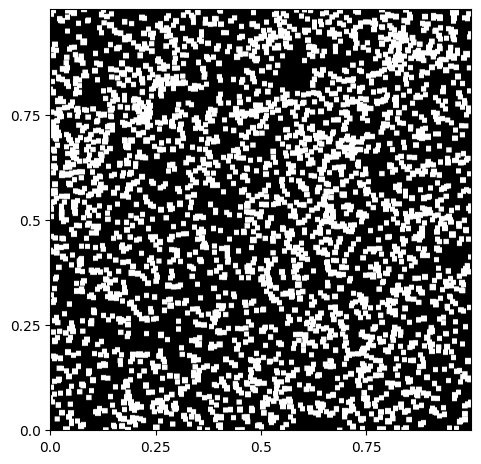

In [33]:
positions = np.linspace(0,dim,5)
labels = np.linspace(0,1,5)

fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_xticks(positions, labels)
ax.set_yticks(positions, labels)

plt.tight_layout()
plt.imshow(array, origin = 'lower', cmap='gray', vmin=0, vmax=1)


In [34]:
def define_grid(fov=45):
    
    gridlines = np.arange(min(ra_pix), max(ra_pix), (fov/3600)*dim)
    return gridlines

gridlines = define_grid()
len(gridlines)

80

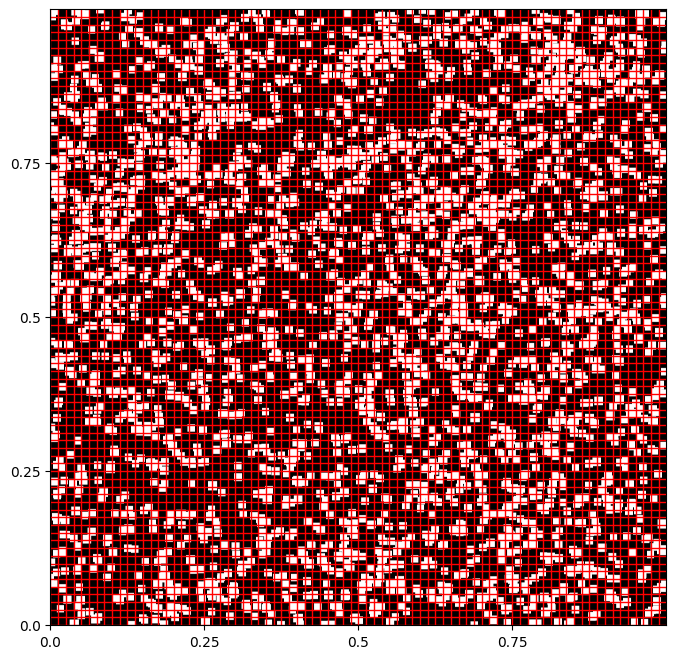

In [35]:
def create_grid():

    # Creating exclusion map with grid
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)

    plt.imshow(array, origin = 'lower', cmap='gray', vmin=0, vmax=1)

    ax.set_xticks(positions, labels)
    ax.set_yticks(positions, labels)    

    plt.vlines(gridlines, min(dec_pix), max(dec_pix), color='red', linewidth=1)
    plt.hlines(gridlines, min(ra_pix), max(ra_pix), color= 'red', linewidth=1)
    plt.margins(0)
    plt.show()

    return

create_grid()

In [36]:
def find_dark_regions():

    # calculating and storing the centre of each dark coord
    centers = []

    for i in range(len(gridlines[:-1])):
        centers.append(int((gridlines[i] + gridlines[i+1])/2 + 0.5))

    x_cen, y_cen = np.meshgrid(centers, centers)

    dark_regions = []

    for i in range(len(gridlines) - 1):
        for j in range(len(gridlines) - 1):
            x_start, x_end = (gridlines[i]).astype(int), (gridlines[i + 1]).astype(int)
            y_start, y_end = (gridlines[j]).astype(int), (gridlines[j + 1]).astype(int)
            
            if np.all(array[y_start:y_end, x_start:x_end] == 0):
                dark_regions.append([x_cen[j, i], y_cen[j, i]])

    dr_trans = np.array(dark_regions).transpose()

    return dr_trans

dr_trans = find_dark_regions()

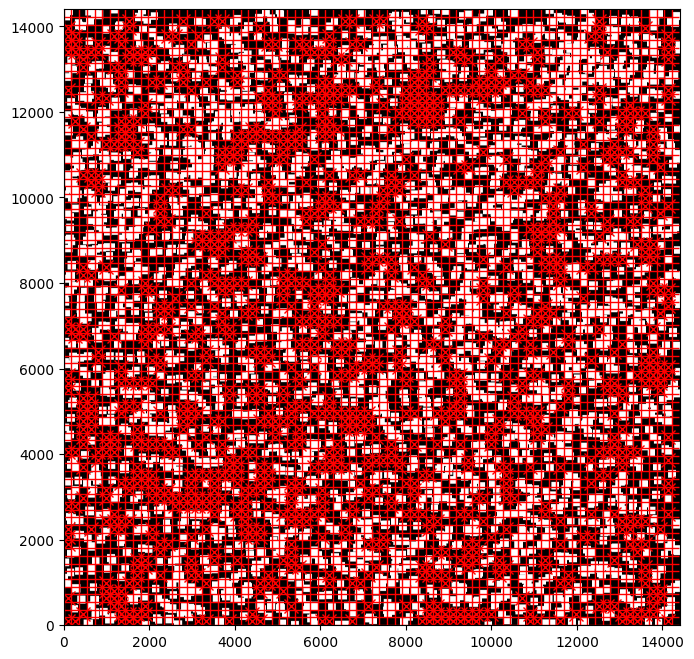

In [37]:
def plot_dark_regions():
    
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)

    plt.imshow(array, origin='lower', cmap='gray', aspect='equal')
    plt.vlines(gridlines, min(dec_pix), max(dec_pix), color='red', linewidth=1)
    plt.hlines(gridlines, min(ra_pix), max(ra_pix), color= 'red', linewidth=1)
    plt.margins(0)
    plt.plot(dr_trans[0], dr_trans[1], 'rx', markersize=10)
    plt.show()

    return

plot_dark_regions()

In [38]:
len(dr_trans[0])

1120